In [1]:
import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
from cvxopt import matrix, sparse
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, utils as ut, network as pnet
from pysar.utils.solvers import l1reg_lstsq
#from pysar.unwrap_error_phase_closure import correct_unwrap_error_closure

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

# specified time-series displacement
tbase = np.array(ts_obj.tbase)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
L = 3 * 9

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt


number of acquisitions: 98
number of sequential connections: 3
number of ifgrams: 288
number of triplets: 286
ifgram with unwrap error: 0.2
unwrap error jump in 2*pi*(-2, 2): 
number of ifgrams with unwrap error: 57


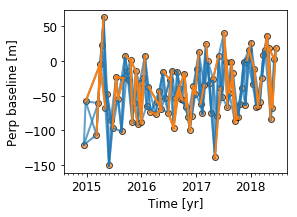

In [2]:
# Network Setup
num_conn = 3
date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of acquisitions: {}'.format(len(ts_obj.dateList)))
print('number of sequential connections: {}'.format(num_conn))
print('number of ifgrams: {}'.format(num_ifgram))
print('number of triplets: {}'.format(C.shape[0]))

# simulate ifgram without unwrap error
ifgram_sim = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid, L=3*9, num_sample=1, baseline_file='bl_list.txt', sensor_name=sensor_name, inc_angle=inc_angle)[0].flatten()
# add unwrap error
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram_sim, percentage=0.2, Nmax=2, print_msg=True)

# plot
fig, ax = plt.subplots(figsize=[4, 3])
# 1. plot acquisitions
ax.plot(ts_obj.times, ts_obj.pbase, 'ko', alpha=0.7, ms=6, mfc=pp.mplColors[1])
# 2. plot all interferometric pairs
for date12 in date12_list:
    date1, date2 = date12.split('_')
    idx1 = ts_obj.dateList.index(date1)
    idx2 = ts_obj.dateList.index(date2)
    x = [ts_obj.times[idx1], ts_obj.times[idx2]]
    y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=0.7, c=pp.mplColors[0])
# 3. plot interferometric pairs with error
for date12 in np.array(date12_list)[idx_ifg_err]:
    date1, date2 = date12.split('_')
    idx1 = ts_obj.dateList.index(date1)
    idx2 = ts_obj.dateList.index(date2)
    x = [ts_obj.times[idx1], ts_obj.times[idx2]]
    y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
# axis format
pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
ax.set_xlabel('Time [yr]', fontsize=font_size)
ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
plt.show()

In [8]:
## Correct unwrapping error based on the phase closure
ifgram = np.array(ifgram_err)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(float)
num_tri, num_ifgram = C.shape
ifgram = ifgram.reshape(num_ifgram, -1)

# 1. calculate the integer ambiguity of the closure phase
closure_pha = np.dot(C, ifgram)
closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))

# 2. solve the integer ambiguity using LASSO regression
A = matrix(-C)
b = matrix(closure_int)
U = np.round(l1reg_lstsq(A, b, lambd=1e-2))

# 3. correct unwrap error
ifgram_cor = ifgram + 2.0*np.pi*U
ifgram_cor = ifgram_cor.flatten()

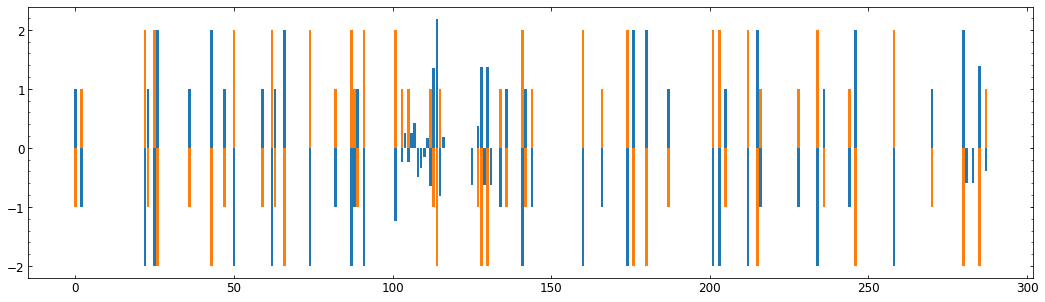

In [26]:
x = np.array(l1reg_lstsq(A, b, lambd=1e-2)).flatten()
fig, ax = plt.subplots(figsize=[18, 5])
ax.bar(np.arange(x.size), (ifgram_err - ifgram_sim) / (2.0*np.pi), color=pp.mplColors[1], label='error before')
ax.bar(np.arange(x.size), x)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
plt.show()

Error percentage: 0.20 -> 0.05
saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/unw_error_idx.png


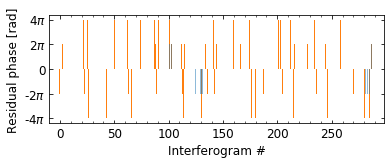

In [34]:
# plot
fig, ax = plt.subplots(figsize=[6, 2])
x_list = np.arange(num_ifgram)
ax.bar(x_list, ifgram_err - ifgram_sim, color=pp.mplColors[1], label='error before')
ax.bar(x_list, ifgram_cor - ifgram_sim, color=pp.mplColors[0], label='error after', alpha=0.5)
#ax.bar(x_list, U.flatten() * 2.0*np.pi, color=pp.mplColors[0], label='error after')#, alpha=0.5)
# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
ax.set_xlim(-10, ifgram_sim.shape[0]+10)

# error percentage
perc0 = np.sum(np.abs(ifgram_err - ifgram_sim) > 0.1) / num_ifgram
perc1 = np.sum(np.abs(ifgram_cor - ifgram_sim) > 0.1) / num_ifgram
print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))

#
out_file = os.path.join(work_dir, 'unw_error_idx.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

Error percentage: 0.20 -> 0.05
saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/err_ifgram_num.png


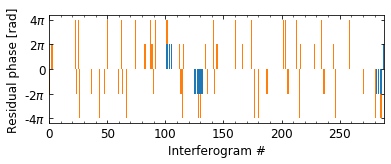

In [11]:
## Fig. 4a - unwrapping-error interferogram number before / after the correction.
fig, ax = plt.subplots(figsize=[6, 2])
wid = 1
x = np.arange(num_ifgram)+1 - wid/2.
ax.bar(x, ifgram_err - ifgram_sim, width=wid, color=pp.mplColors[1])
ax.bar(x, ifgram_cor - ifgram_sim, width=wid, color=pp.mplColors[0])

# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
ax.set_xlim(0, ifgram_sim.shape[0])

# error percentage
perc0 = np.sum(np.abs(ifgram_err - ifgram_sim) > 0.1) / num_ifgram
perc1 = np.sum(np.abs(ifgram_cor - ifgram_sim) > 0.1) / num_ifgram
print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))

# output
out_file = os.path.join(work_dir, 'err_ifgram_num.png')
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

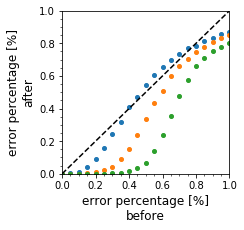

In [14]:
## Fig. 4b - performance as a function of error frequency

pfiles = ['stats_05cycle_03conn.pickle', 
          'stats_05cycle_05conn.pickle', 
          'stats_05cycle_10conn.pickle']

fig, ax = plt.subplots(figsize=[3,3])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ms = 2
for i in range(len(pfiles)):
    pfile = pfiles[i]
    with open(pfile, 'rb') as f:
        ds = pickle.load(f)
    ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i])
    #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i])
ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('error percentage [%]\nbefore', fontsize=font_size)
ax.set_ylabel('error percentage [%]\nafter', fontsize=font_size)
plt.show()

Error percentage: 0.10 -> 0.02
saved to file sim_phase_closure.png


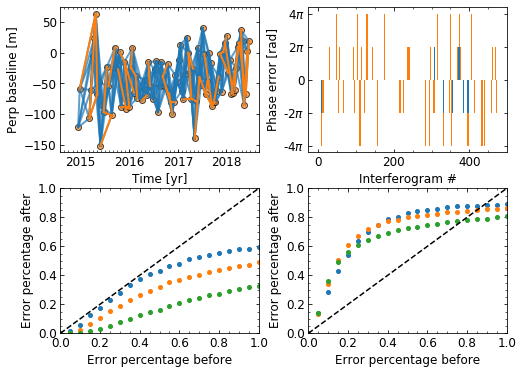

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 6])
plot_network(axs[0,0], date12_list, idx_ifg_err, ts_obj)
plot_ifgram_bar(axs[0,1], ifgram_sim, ifgram_err, ifgram_cor)
#plot_timeseries(axs[1,0], ts_sim, ts_err, ts_cor, ts_obj)
plot_percentage(axs[1,0], conn_list=[3,5,10], max_cycle=2)
plot_percentage(axs[1,1], conn_list=[3,5,10], max_cycle=10)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
#fig.tight_layout()

# axis format
for ax in axs.flatten():
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
out_file = 'sim_phase_closure.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

In [11]:
## Run performance
test = False

step = 0.05
Nmax = 5 # 2, 10
percentage0s = np.arange(0, 1+step, step)
for num_conn in [3,5,10]:   #[3,5,10]
    out_file = 'stats_{:02d}cycle_{:02d}conn.pickle'.format(Nmax, num_conn)
    if test or not os.path.isfile(out_file):
        percentage1s = phase_closure_performance(num_conn, Nmax, step=step, num_rep=100)

        if not test:
            # save to pickle file
            ds = {}
            ds['num_conn'] = num_conn
            ds['percentage0'] = percentage0s
            ds['percentage1'] = percentage1s
            with open(out_file, 'wb') as f:
                pickle.dump(ds, f)
            print('saved to pickle file {}.'.format(out_file))
            ds = dict(ds)
    else:
        print('{} exists, skip to the next.'.format(out_file))
print('Done.')

stats_05cycle_03conn.pickle exists, skip to the next.
stats_05cycle_05conn.pickle exists, skip to the next.
stats_05cycle_10conn.pickle exists, skip to the next.
Done.


NameError: name 'percentage1s' is not defined

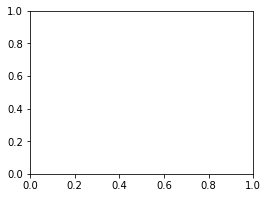

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 3])
ax.plot(percentage0s, percentage1s, 'o', ms=2**2, color=pp.mplColors[0], label='percentange 1')

ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend()
# save
#out_file = 'plot_stats_{:02d}cycle_D{:d}.png'.format(Nmax, int(D))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
#print('saved to file', out_file)
plt.show()

In [ ]:


if not pickle_files:
    return ax
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ms = 2
for i in range(len(pickle_files)):
    pickle_file = pickle_files[i]
    with open(pickle_file, 'rb') as f:
        ds = pickle.load(f)
    ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i])
    #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i])
ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('Error percentage before', fontsize=font_size)
ax.set_ylabel('Error percentage after', fontsize=font_size)



In [8]:
def correct_unwrap_error_closure(ifgram, C):
    """Estimate unwrapping error from a stack of unwrapped interferometric phase
    Parameters: ifgram : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase in float32
                C      : 2D np.array in size of (num_triangle, num_ifgram) triangle design matrix in float64
    Returns:    ifgram_cor : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase after correction
                U          : 2D np.array in size of (num_ifgram, num_pixel) of phase jump integer
    Example:    ifgram_cor, U = estimate_unwrap_error(ifgram, C)
    """
    ifgram = ifgram.reshape(C.shape[1], -1)

    # 1. calculate the integer ambiguity of the closure phase
    closure_pha = np.dot(C, ifgram)
    closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))

    # 2. solve the integer ambiguity using LASSO regression
    A = matrix(-C)
    b = matrix(closure_int)
    U = np.round(l1reg_lstsq(A, b, lambd=1e-2))

    # 3. correct unwrap error
    ifgram_cor = ifgram + 2.0*np.pi*U
    return ifgram_cor, U


def phase_closure_performance(num_conn=3, Nmax=2, step=0.05, num_rep=100):
    # simulate ifgram without unw err
    date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
    num_ifgram = len(date12_list)
    C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(float)
    #print('number of connections:', num_conn)
    print('number of ifgrams: {}'.format(num_ifgram))
    print('number of triplets: {}'.format(C.shape[0]))

    ifgram = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                  L=L, num_sample=1,
                                  baseline_file='bl_list.txt',
                                  sensor_name=sensor_name,
                                  inc_angle=inc_angle)[0].flatten()

    # calculate percentage change for various percentage of unw err
    print('calculating the improvement of unw err correction for various percentage of errors ...')
    percentage0s = np.arange(0, 1+step, step)
    num_step = percentage0s.shape[0]
    percentage1s = np.zeros(num_step, np.float32)
    prog_bar = ptime.progressBar(maxValue=num_step)
    for i in range(num_step):
        perc1 = 0
        for j in range(num_rep):
            ifgram_err = sim.add_unw_err2ifgram(ifgram, percentage=percentage0s[i], Nmax=Nmax, print_msg=False)[0]
            ifgram_cor = correct_unwrap_error_closure(ifgram_err, C)[0].flatten()
            perc1 += np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
        perc1 /= num_rep
        percentage1s[i] = perc1
        prog_bar.update(i+1)
    prog_bar.close()
    return percentage1s

print('Done.')

Done.


In [36]:
## ploting functions
def plot_network(ax, date12_list, idx_ifg_err, ts_obj):
    # plot acquisitions
    ax.plot(ts_obj.times, ts_obj.pbase, 'ko', alpha=0.7, ms=6, mfc=pp.mplColors[1])
    # plot all interferometric pairs
    for date12 in date12_list:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=0.7, c=pp.mplColors[0])
    # plot interferometric pairs with error
    for date12 in np.array(date12_list)[idx_ifg_err]:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
    # axis format
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
    return ax

def plot_ifgram_bar(ax, ifgram, ifgram_err, ifgram_cor):
    wid = 3
    num_ifgram = len(ifgram)
    x = np.arange(num_ifgram)+1 - wid/2.
    ax.bar(x, ifgram_err - ifgram, width=wid, color=pp.mplColors[1])
    ax.bar(x, ifgram_cor - ifgram, width=wid, color=pp.mplColors[0])
    # error percentage
    perc0 = np.sum(np.abs(ifgram_err - ifgram) > 0.1) / num_ifgram
    perc1 = np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
    # axis format
    #ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
    ax.set_xlabel('Interferogram #', fontsize=font_size)
    ax.set_ylabel('Phase error [rad]', fontsize=font_size)
    print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))
    return ax

def plot_timeseries(ax, ts_sim, ts_err, ts_cor, ts_obj):
    ax.plot(ts_obj.times, ts_sim * 100., 'k--', label='truth')
    ax.plot(ts_obj.times, ts_err * 100., 'o', mec=pp.mplColors[1], mfc='none', mew=1.5, label='before cor')
    ax.plot(ts_obj.times, ts_cor * 100., 's', color=pp.mplColors[0], alpha=0.5, label='after cor')
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
    #ax.legend(fontsize=font_size)
    return ax

def plot_percentage(ax, pickle_files=[]):
    if not pickle_files:
        return ax
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ms = 2
    for i in range(len(pickle_files)):
        pickle_file = pickle_files[i]
        with open(pickle_file, 'rb') as f:
            ds = pickle.load(f)
        ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i])
        #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i])
    ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel('Error percentage before', fontsize=font_size)
    ax.set_ylabel('Error percentage after', fontsize=font_size)
    return ax
print('Done.')

Done.
